# Projeto Final - Codenation Data Science - JOINVILLE

# SQUAD 1 - Objetivo

O objetivo deste produto é fornecer um serviço automatizado que recomenda leads para um usuário dado sua atual lista de clientes (Portfólio).

# Contextualização
Algumas empresas gostariam de saber quem são as demais empresas em um determinado mercado (população) que tem maior probabilidade se tornarem seus próximos clientes. Ou seja, a solução deve encontrar no mercado quem são os leads mais aderentes dado as características dos clientes presentes no portfólio do usuário.

Além disso, a solução deve ser agnóstica ao usuário. Qualquer usuário com uma lista de clientes que queira explorar esse mercado pode extrair valor do serviço.

Para o desafio, deverão ser consideradas as seguintes bases:

Mercado: Base com informações sobre as empresas do Mercado a ser considerado. Portfolio 1: Ids dos clientes da empresa 1 Portfolio 2: Ids dos clientes da empresa 2 Portfolio 3: Ids dos clientes da empresa 3

Obs: todas as empresas(ids) dos portfolios estão contidos no Mercado(base de população).

As bases de portfólio poderão ser utilizadas para testar a aderência da solução. Além disso, se a equipe desejar, poderá simular portfólios por meio de amostragens no mercado.

Premissas:

1. Não serão considerados os dados de "coligados"
2. Não serão considerado o relacionamento entre filial/matriz, cada cliente será avaliado individualmente

In [329]:
#Importando as bibliotecas
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [330]:
from IPython.core.pylabtools import figsize

figsize(12, 8)

sns.set()

## Importando os Arquivos

In [331]:
#Importando o Dataframe de Mercado e eliminando os dados 
mercado_orig = pd.read_csv('estaticos_market.csv')
mercado = mercado_orig.copy()

mercado = mercado.drop(['Unnamed: 0'] , axis='columns')
mercado = mercado.drop(['fl_antt'] , axis='columns')
mercado = mercado.drop(['vl_total_tancagem'] , axis='columns')
mercado = mercado.drop(['de_faixa_faturamento_estimado'] , axis='columns')
mercado = mercado.drop(['vl_frota'] , axis='columns')

# Não serão considerados os dados relacionados as contratações dos funcionarios no periodo - Apenas a quantidade atual de funcionários da empresa
mercado = mercado.drop(['meses_ultima_contratacaco'] , axis='columns')
mercado = mercado.drop(['qt_admitidos_12meses'] , axis='columns')
mercado = mercado.drop(['qt_desligados_12meses'] , axis='columns')
mercado = mercado.drop(['qt_desligados'] , axis='columns')
mercado = mercado.drop(['qt_admitidos'] , axis='columns')
mercado = mercado.drop(['qt_funcionarios_12meses'] , axis='columns')
mercado = mercado.drop(['qt_funcionarios_24meses'] , axis='columns')
mercado = mercado.drop(['tx_crescimento_12meses'] , axis='columns')
mercado = mercado.drop(['tx_crescimento_24meses'] , axis='columns')
mercado = mercado.drop(['tx_rotatividade'] , axis='columns')
mercado = mercado.drop(['min_meses_servicos'] , axis='columns')
mercado = mercado.drop(['min_meses_servicos_all'] , axis='columns')
mercado = mercado.drop(['max_meses_servicos_all'] , axis='columns')
mercado = mercado.drop(['grau_instrucao_macro_desconhecido'] , axis='columns')
mercado = mercado.drop(['empsetorcensitariofaixarendapopulacao'] , axis='columns')
mercado = mercado.drop(['nu_meses_rescencia'] , axis='columns')
mercado = mercado.drop(['vl_potenc_cons_oleo_gas'] , axis='columns')
mercado = mercado.drop(['qt_ex_funcionarios'] , axis='columns')
mercado = mercado.drop(['percent_func_genero_masc'] , axis='columns')
mercado = mercado.drop(['percent_func_genero_fem'] , axis='columns')
mercado = mercado.drop(['fl_spa'] , axis='columns')
mercado = mercado.drop(['dt_situacao'] , axis='columns')

# Não serão considerados os valores relacionados as coligadas
lista_remove = [x for x in mercado.columns if 'colig' in x ]
mercado = mercado.drop(lista_remove , axis='columns')

# Não serão considerados os dados relacionados aos sócios - Apenas a quantidade atual de sócios
lista_remove = [x for x in mercado.columns if 'socio' in x ]
lista_remove.remove('qt_socios')
mercado = mercado.drop(lista_remove , axis='columns')

# Não serão considerados os dados de Ramo, Segmento e Divisão - Consideraremos o dado de setor para agrupamento dos clientes
mercado = mercado.drop(['de_ramo'] , axis='columns')
mercado = mercado.drop(['nm_segmento'] , axis='columns')
mercado = mercado.drop(['nm_divisao'] , axis='columns')
mercado = mercado.drop(['de_natureza_juridica'] , axis='columns')

# Não serão consideradas as idades dos funcionários para avaliação do cliente
lista_remove = [x for x in mercado.columns if 'idade_de' in x ]
mercado = mercado.drop(lista_remove, axis='columns')
lista_remove = [x for x in mercado.columns if 'idade_ate' in x ]
mercado = mercado.drop(lista_remove, axis='columns')
lista_remove = [x for x in mercado.columns if 'idade_acima' in x ]
mercado = mercado.drop(lista_remove, axis='columns')

# Não serão consideradas as graus de instrução dos funcionários para avaliação do cliente
lista_remove = [x for x in mercado.columns if 'grau_instrucao_macro' in x ]
mercado = mercado.drop(lista_remove, axis='columns')

# Não serão consideradas as meses de serviço dos funcionários para avaliação do cliente
lista_remove = [x for x in mercado.columns if 'meses_servicos' in x ]
mercado = mercado.drop(lista_remove, axis='columns')

# Não serão considerados os dados de veículos
lista_remove = [x for x in mercado.columns if 'veiculo' in x ]
mercado = mercado.drop(lista_remove, axis='columns')

# Não serão considerados os dados de e-mail e telefone
mercado = mercado.drop(['fl_email'] , axis='columns')
mercado = mercado.drop(['fl_telefone'] , axis='columns')
mercado = mercado.drop(['de_indicador_telefone'] , axis='columns')

# Não serão considerados os dados de impostos
mercado = mercado.drop(['fl_passivel_iss'] , axis='columns')
mercado = mercado.drop(['fl_st_especial'] , axis='columns')

# Não serão considerados os dados de Matriz/Grupo
lista_remove = [x for x in mercado.columns if 'matriz' in x ]
mercado = mercado.drop(lista_remove, axis='columns')

# Não serão considerados os dados de Saude
lista_remove = [x for x in mercado.columns if 'saude' in x ]
mercado = mercado.drop(lista_remove, axis='columns')

# Não serão considerados os dados de Matriz/Grupo
lista_remove = [x for x in mercado.columns if 'grupo' in x ]
mercado = mercado.drop(lista_remove, axis='columns')
# mercado = mercado.drop['setor']

In [332]:
mercado[mercado.vl_faturamento_estimado_aux.isna()].vl_faturamento_estimado_aux

7        NaN
32       NaN
36       NaN
76       NaN
80       NaN
102      NaN
122      NaN
163      NaN
173      NaN
194      NaN
202      NaN
224      NaN
227      NaN
238      NaN
259      NaN
273      NaN
312      NaN
336      NaN
337      NaN
364      NaN
370      NaN
376      NaN
382      NaN
385      NaN
391      NaN
406      NaN
432      NaN
499      NaN
505      NaN
521      NaN
          ..
461761   NaN
461791   NaN
461793   NaN
461805   NaN
461810   NaN
461811   NaN
461912   NaN
461929   NaN
461931   NaN
461972   NaN
461977   NaN
461980   NaN
461986   NaN
462009   NaN
462050   NaN
462065   NaN
462094   NaN
462095   NaN
462099   NaN
462106   NaN
462139   NaN
462142   NaN
462150   NaN
462151   NaN
462170   NaN
462172   NaN
462205   NaN
462224   NaN
462226   NaN
462274   NaN
Name: vl_faturamento_estimado_aux, Length: 27513, dtype: float64

In [333]:
# Importando o Dataframe de Portfolio1
portfolio1 = pd.read_csv('estaticos_portfolio1.csv')
portfolio1 = portfolio1.drop(['Unnamed: 0'] , axis='columns')
# Deixando somente o id no portfolio
lista_port1 = list(portfolio1.columns)
lista_port1.remove('id')
portfolio1 = portfolio1.drop(lista_port1, axis='columns')
portfolio1.head()

,id
0,dabe79bec87c88ae04e869bf6bd321ee5e1893cecf6625...
1,32e5f4e10932153a7ba869cb0386e7e02d49d2461046b8...
2,a95d6f30bba445bd3d6b0c5b36f865b38ec01d17336090...
3,6cb309685cea0b6d2988818792ec2e6fcb2bd02e0afa9e...
4,f72aa7fa6787b0a5a1c88885b6120850df8ee0f71adc25...


In [334]:
# Importando o Dataframe de Portfolio2
portfolio2 = pd.read_csv('estaticos_portfolio2.csv')
portfolio2 = portfolio2.drop(['Unnamed: 0'] , axis='columns')
#portfolio2 = pd.merge(portfolio2, mercado, on='id', how='inner')
portfolio2.head()

,id
0,09e95c1a84049001d086470a8f320a19b076f955a89122...
1,dc9d155f5bcd3172031e2ec9431786e8871ff4b0ff4728...
2,16843c9ffb920170477118933798510d8d5f00f5c56c12...
3,ff045934d90aab184dd15e66daf3b3c97193bda5449298...
4,a0ce528caab2c62497a548d0ebd9e935143ef81ed7dbf0...


In [335]:
# Importando o Dataframe de Portfolio3
portfolio3 = pd.read_csv('estaticos_portfolio3.csv')
portfolio3 = portfolio3.drop(['Unnamed: 0'] , axis='columns')
#portfolio3 = pd.merge(portfolio3, mercado, on='id', how='inner')
portfolio3.head()

,id
0,bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe2...
1,16843c9ffb920170477118933798510d8d5f00f5c56c12...
2,1b8d092daff12bed8b3c2ab93bf5df2921865a68aca185...
3,3aafa3a1f12f483740a52956af100223333d0e3c79bf2c...
4,c60431fbca90067f105570e1e8a684bcd7048205bbf6c4...


## Iniciando as Análises dos Arquivos

Nesse momento avaliaremos os dados do dataframe

In [336]:
# 5 Primeiras Linhas
mercado.head()

,id,sg_uf,natureza_juridica_macro,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,...,fl_optante_simei,de_nivel_atividade,fl_simples_irregular,nm_meso_regiao,nm_micro_regiao,qt_socios,vl_faturamento_estimado_aux,total,qt_funcionarios,qt_filiais
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,RN,ENTIDADES EMPRESARIAIS,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,False,False,False,...,False,ALTA,False,LESTE POTIGUAR,NATAL,2.0,3132172.8,26.0,26.0,0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,PI,OUTROS,SERVIÇO,1.463014,1 a 5,False,False,False,True,...,NaN,BAIXA,False,CENTRO NORTE PIAUIENSE,TERESINA,1.0,210000.0,NaN,NaN,0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,AM,OUTROS,SERVIÇO,7.093151,5 a 10,False,False,False,True,...,True,MEDIA,False,CENTRO AMAZONENSE,MANAUS,1.0,50000.0,NaN,NaN,0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,AM,OUTROS,SERVIÇO,6.512329,5 a 10,False,False,False,False,...,False,MEDIA,False,CENTRO AMAZONENSE,MANAUS,1.0,210000.0,NaN,NaN,0
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,RN,OUTROS,SERVIÇO,3.200000,1 a 5,False,False,False,False,...,False,ALTA,False,LESTE POTIGUAR,NATAL,1.0,210000.0,NaN,NaN,0


In [337]:
#Verificando Quantidade de Colunas e Observações
mercado.shape

(462298, 24)

In [338]:
#Verificando a quantidade valores nulos por coluna
mercado.isnull().sum()

id                                  0
sg_uf                               0
natureza_juridica_macro             0
setor                            1927
idade_empresa_anos                  0
idade_emp_cat                       0
fl_me                               0
fl_sa                               0
fl_epp                              0
fl_mei                              0
fl_ltda                             0
fl_rm                               0
fl_optante_simples              82713
qt_art                         455708
fl_optante_simei                82713
de_nivel_atividade              11168
fl_simples_irregular             1927
nm_meso_regiao                  58698
nm_micro_regiao                 58698
qt_socios                      115091
vl_faturamento_estimado_aux     27513
total                          386356
qt_funcionarios                358724
qt_filiais                          0
dtype: int64

In [339]:
#Avaliação do mercado que estão sem setor
mercado.groupby('setor').id.count()

setor
AGROPECUARIA          3247
COMERCIO            211224
CONSTRUÇÃO CIVIL     25363
INDUSTRIA            30893
SERVIÇO             189644
Name: id, dtype: int64

In [340]:
## ONE HOT ENCODE: DE_NIVEL_ATIVIDADE, SETOR_UNIQUE (TROCAR NAN PARA OUTROS), NATUREZA_JURIDICA_MACRO, SG_UF (VERIFICAR NECESSIDADE)
# dfDummiesNivelAtividade = pd.get_dummies(mercado['de_nivel_atividade'],prefix='NIVEL_ATIVIDADE_OHE')

In [341]:
## ONE HOT ENCODE: DE_NIVEL_ATIVIDADE, SETOR_UNIQUE (TROCAR NAN PARA OUTROS), NATUREZA_JURIDICA_MACRO, SG_UF (VERIFICAR NECESSIDADE)
# dfDummiesNaturezaJuridica = pd.get_dummies(mercado['natureza_juridica_macro'],prefix='NATUREZA_JURIDICA_OHE')

In [342]:
#Atualizando DF


In [343]:
df_copy = mercado_orig.copy()
df_copy = df_copy[df_copy.vl_faturamento_estimado_aux != 0]
df_setor = pd.DataFrame(round(df_copy.groupby('setor').vl_faturamento_estimado_aux.mean(), 2)).reset_index()

In [344]:
mercado_orig.groupby('setor').vl_faturamento_estimado_aux.mean().round(1)

setor
AGROPECUARIA        1229622.3
COMERCIO             445014.4
CONSTRUÇÃO CIVIL     657964.5
INDUSTRIA           1398885.6
SERVIÇO             1127868.1
Name: vl_faturamento_estimado_aux, dtype: float64

In [345]:
# mercado.sh

In [346]:
def bla (row):
    if float(row.vl_faturamento_estimado_aux) >= 0:
        return row.vl_faturamento_estimado_aux 
    return fnas.get(row.setor)

In [347]:
# fnas = {
#         'AGROPECUARIA':  1229622.3,
#         'COMERCIO': 445014.4,
#         'CONSTRUÇÃO CIVIL': 657964.5,
#         'INDUSTRIA': 1398885.6,
#         'SERVIÇO': 1127868.1,
#     }

# mercado['vl_faturamento_estimado_aux'] = mercado.apply(bla, axis=1)
mercado["vl_faturamento_estimado_aux"].fillna(mercado.groupby("setor")["vl_faturamento_estimado_aux"].transform("mean"), inplace=True)


# .apply(lambda x: fnas[1] if x.vl_faturamento_estimado_aux == None && x.setor == fnas[0])

# # mercado.shape
# for fna in fnas.items():
# #     mercado.loc[mercado['vl_faturamento_estimado_aux'] == 0, 'rating'] = 0 
# #     mercado['vl_faturamento_estimado_aux'] = np.where(mercado['setor'] == key && mercado['vl_faturamento_estimado_aux'], 1.0, 0.0)
# #     mercado.vl_faturamento_estimado_aux.apply(lambda x: )
#     mercado.vl_faturamento_estimado_aux = mercado[mercado.setor == fna[0]].vl_faturamento_estimado_aux.fillna(fna[1])

In [348]:
mercado.vl_faturamento_estimado_aux[mercado.vl_faturamento_estimado_aux.isna()]

98505    NaN
141832   NaN
Name: vl_faturamento_estimado_aux, dtype: float64

In [349]:
# mercado = mercado.drop(['de_nivel_atividade'] , axis='columns')
# mercado = mercado.drop(['natureza_juridica_macro'] , axis='columns')
# mercado = mercado.drop(['sg_uf'] , axis='columns')

In [350]:
#Verificando a quantidade valores nulos por coluna
media_qt_art = round(mercado.qt_art.mean(),0)
media_qt_art

6.0

In [351]:
#Atualizando Medina nos valores null da QT_ART
mercado.qt_art.fillna(media_qt_art, inplace=True)

In [352]:
## TROCAR NAN FL_* PARA FALSE
mercado.fl_optante_simei.fillna(False, inplace=True)
mercado.fl_optante_simples.fillna(False, inplace=True)
mercado.fl_simples_irregular.fillna(False, inplace=True)

In [353]:
# ATUALIZANDO QUANTIDADE FUNCIONARIOS E SOCIOS
mercado.qt_funcionarios.fillna(1, inplace=True)
mercado.qt_socios.fillna(1, inplace=True)

In [354]:
mercado.nm_meso_regiao.fillna('OUTRA', inplace=True)
mercado.nm_micro_regiao.fillna('OUTRA', inplace=True)
mercado.isna().sum()

id                                  0
sg_uf                               0
natureza_juridica_macro             0
setor                            1927
idade_empresa_anos                  0
idade_emp_cat                       0
fl_me                               0
fl_sa                               0
fl_epp                              0
fl_mei                              0
fl_ltda                             0
fl_rm                               0
fl_optante_simples                  0
qt_art                              0
fl_optante_simei                    0
de_nivel_atividade              11168
fl_simples_irregular                0
nm_meso_regiao                      0
nm_micro_regiao                     0
qt_socios                           0
vl_faturamento_estimado_aux         2
total                          386356
qt_funcionarios                     0
qt_filiais                          0
dtype: int64

In [355]:
mercado = mercado.drop(['nm_meso_regiao'] , axis='columns')

In [356]:
mercado = mercado.drop(['nm_micro_regiao'] , axis='columns')

In [357]:
mercado = mercado.drop(['total'] , axis='columns')

In [358]:
mercado.columns = mercado.columns.str.replace(" ", "_")

In [359]:
# mercado[mercado.vl_faturamento_estimado_aux.isna()].head(3).apply(bla, axis=1)

In [360]:
# mercado = mercado.drop(['setor'] , axis='columns')

In [361]:
mercado = mercado.drop(['idade_empresa_anos'] , axis='columns')

In [362]:
mercado = mercado.drop(['fl_rm'], axis='columns')

In [363]:
mercado = mercado.drop(['qt_art'], axis='columns')

In [364]:
mercado = mercado.drop(['qt_socios'], axis='columns')

In [365]:
mercado = mercado.drop(['qt_filiais'], axis='columns')

In [366]:
mercado = mercado.drop(['qt_funcionarios'], axis='columns')

In [367]:
#lista_remove = [x for x in mercado.columns if 'fl_' in x ]
#mercado = mercado.drop(lista_remove, axis='columns')

In [368]:
#mercado = mercado.drop(['vl_faturamento_estimado_aux'] , axis='columns')

In [369]:
train_labels = mercado.pop('id')

In [370]:
mercado.isna().sum()

sg_uf                              0
natureza_juridica_macro            0
setor                           1927
idade_emp_cat                      0
fl_me                              0
fl_sa                              0
fl_epp                             0
fl_mei                             0
fl_ltda                            0
fl_optante_simples                 0
fl_optante_simei                   0
de_nivel_atividade             11168
fl_simples_irregular               0
vl_faturamento_estimado_aux        2
dtype: int64

In [371]:
mercado[mercado.vl_faturamento_estimado_aux.isna()][['setor', 'vl_faturamento_estimado_aux']]
print(mercado.shape)
mercado = mercado.dropna()
print(mercado.shape)

(462298, 14)
(451130, 14)


In [372]:
## ONE HOT ENCODE: DE_NIVEL_ATIVIDADE, SETOR_UNIQUE (TROCAR NAN PARA OUTROS), NATUREZA_JURIDICA_MACRO, SG_UF (VERIFICAR NECESSIDADE)
label_encoder = LabelEncoder()
mercado.setor = label_encoder.fit_transform(mercado.setor)

In [373]:
## ONE HOT ENCODE: DE_NIVEL_ATIVIDADE, SETOR_UNIQUE (TROCAR NAN PARA OUTROS), NATUREZA_JURIDICA_MACRO, SG_UF (VERIFICAR NECESSIDADE)
label_encoder = LabelEncoder()
mercado.sg_uf = label_encoder.fit_transform(mercado.sg_uf)

In [374]:
label_encoder = LabelEncoder()
mercado.idade_emp_cat = label_encoder.fit_transform(mercado.idade_emp_cat)

In [375]:
label_encoder = LabelEncoder()
mercado.de_nivel_atividade = label_encoder.fit_transform(mercado.de_nivel_atividade)

In [376]:
label_encoder = LabelEncoder()
mercado.natureza_juridica_macro = label_encoder.fit_transform(mercado.natureza_juridica_macro)

In [377]:
mercado_orig.head()

,Unnamed: 0,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,...,43.738462,93.266667,19.166667,26.0,26.0,27.0,0.0,-3.703704,0.0,0
1,1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,SERVICOS DIVERSOS,SERVIÇO,6.512329,5 a 10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,1 a 5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [378]:
mercado.vl_faturamento_estimado_aux = ((mercado["vl_faturamento_estimado_aux"]-mercado["vl_faturamento_estimado_aux"].min())/(mercado["vl_faturamento_estimado_aux"].max()-mercado["vl_faturamento_estimado_aux"].min()))*20

In [379]:
pca = PCA(0.95)
bla = pca.fit_transform(mercado)
blaDf= pd.DataFrame(bla)

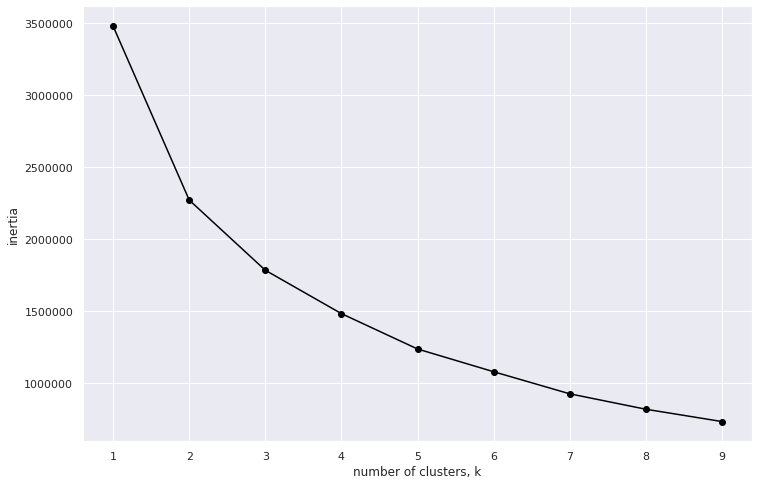

In [380]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(blaDf.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

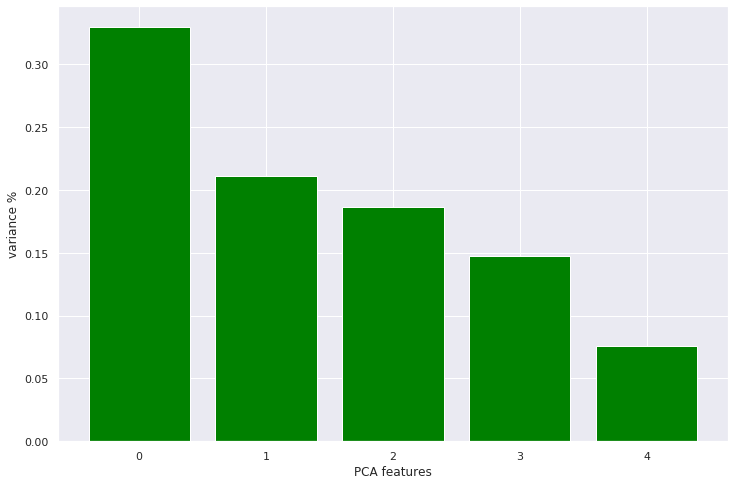

In [381]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='green')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

In [382]:
pd.DataFrame(pca.components_,columns=mercado.columns)

,sg_uf,natureza_juridica_macro,setor,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,fl_optante_simples,fl_optante_simei,de_nivel_atividade,fl_simples_irregular,vl_faturamento_estimado_aux
0,-0.013627,-0.208966,-0.001689,0.966323,0.000352,0.002529,0.000000e+00,-0.089856,0.000626,-0.087073,-0.081863,-0.000429,0.000032,0.000446
1,0.259424,-0.498913,0.808760,-0.117377,-0.000093,-0.000380,0.000000e+00,-0.056676,0.002283,-0.066485,-0.038498,-0.082430,0.000045,0.000568
2,-0.964184,-0.100725,0.229049,-0.043059,0.000023,0.001066,-0.000000e+00,-0.032499,0.000291,-0.031922,-0.025428,-0.056242,0.000082,0.000265
3,-0.019731,-0.784385,-0.539579,-0.194612,0.000405,0.003915,1.110223e-16,-0.141738,0.002198,-0.039037,-0.082451,-0.164011,0.000241,0.000603
4,-0.035533,-0.172985,-0.012532,-0.049441,-0.000480,-0.000340,0.000000e+00,-0.008576,-0.000028,-0.090784,-0.035037,0.978094,-0.000310,-0.000559


## K MEANS

In [383]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(bla)
y_kmeans = kmeans.predict(bla)

In [384]:
y_kmeans_Df = pd.DataFrame(y_kmeans)
blazinho = pd.DataFrame(train_labels)
blazinho['result'] = y_kmeans_Df
blazinho.groupby('result').id.count()

result
0.0    143521
1.0     92045
2.0    118756
3.0     96808
Name: id, dtype: int64

In [385]:
portfolio1_filtered = pd.merge(portfolio1, blazinho, on='id', how='inner')
portfolio2_filtered = pd.merge(portfolio2, blazinho, on='id', how='inner')
portfolio3_filtered = pd.merge(portfolio3, blazinho, on='id', how='inner')
portfolio1_filtered.shape
#portfolio3 = pd.merge(portfolio3, mercado, on='id', how='inner')

(555, 2)

In [386]:
portfolio2_filtered.shape

(566, 2)

In [387]:
portfolio3_filtered.shape

(265, 2)

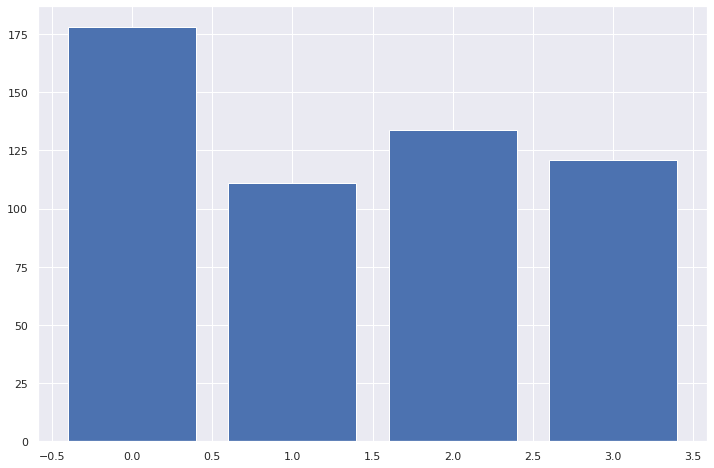

In [388]:
a = pd.DataFrame(portfolio1_filtered.groupby('result').id.count()).reset_index()
a.head()
plt.bar(a.result, a.id)
plt.show()

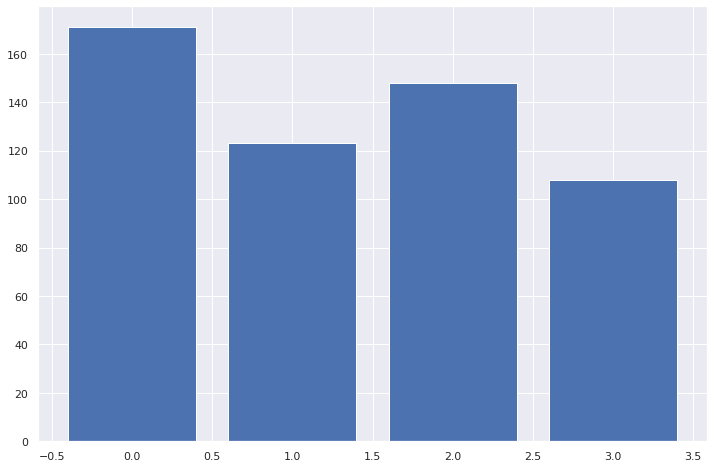

In [389]:
b = pd.DataFrame(portfolio2_filtered.groupby('result').id.count()).reset_index()
b.head()
plt.bar(b.result, b.id)
plt.show()

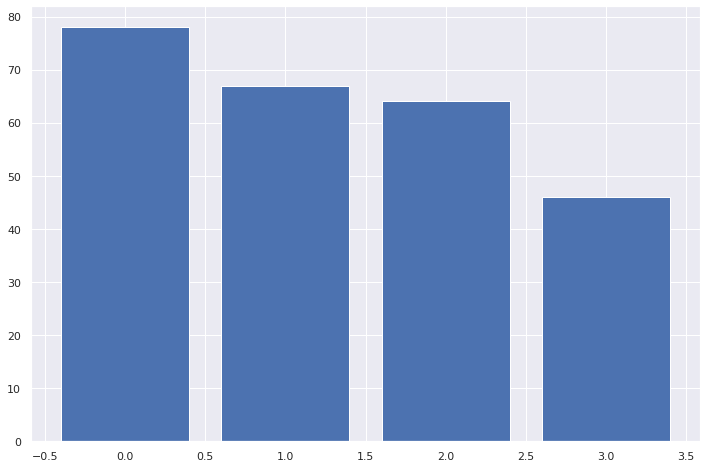

In [390]:
c = pd.DataFrame(portfolio3_filtered.groupby('result').id.count()).reset_index()
c.head()
plt.bar(c.result, c.id)
plt.show()

In [391]:
# plt.bar(blazinho.result, blazinho.id.count())
# plt.show()

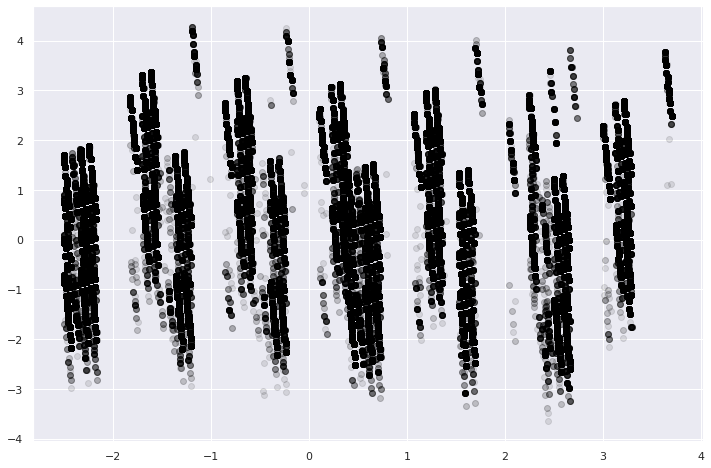

In [392]:
plt.scatter(blaDf[0], blaDf[1], alpha=.1, color='black')
plt.show()

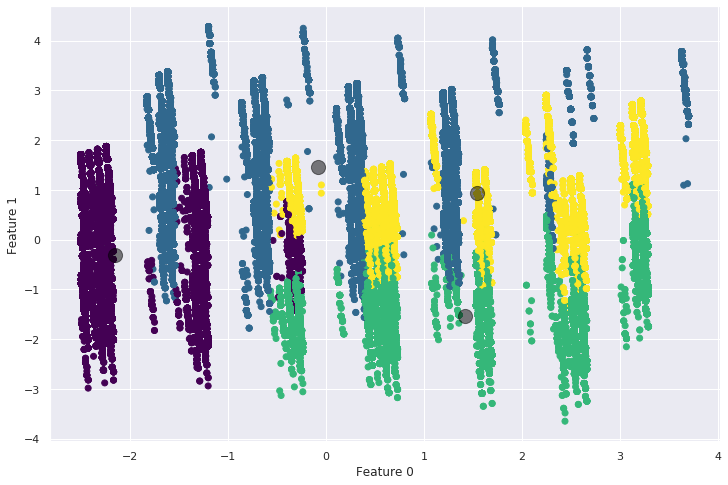

In [393]:
# plot the cluster assignments and cluster centers
centers = kmeans.cluster_centers_
plt.scatter(bla[:, 0], bla[:, 1], c=y_kmeans, cmap="viridis")
plt.scatter(centers[:, 0], centers[:, 1], c="black", s=200, alpha=0.5)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

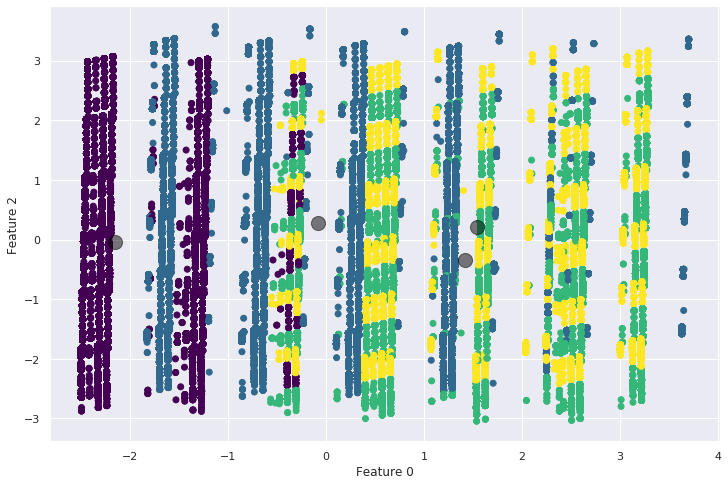

In [394]:
# plot the cluster assignments and cluster centers
plt.scatter(bla[:, 0], bla[:, 2], c=y_kmeans, cmap="viridis")
plt.scatter(centers[:, 0], centers[:, 2], c="black", s=200, alpha=0.5)
plt.xlabel("Feature 0")
plt.ylabel("Feature 2")
plt.show()

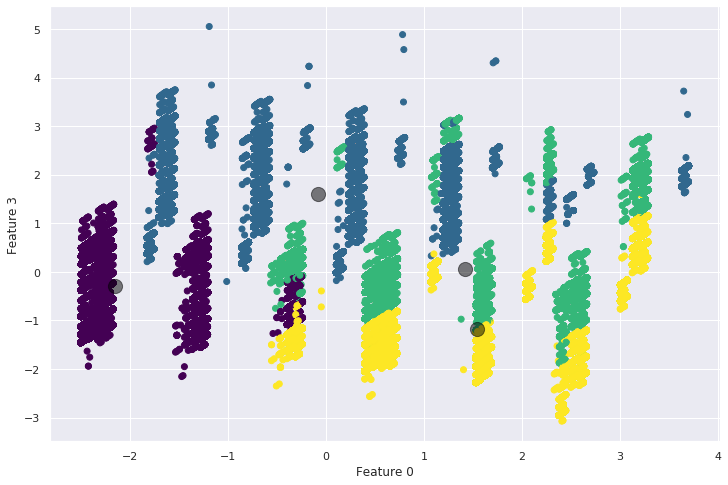

In [395]:
# plot the cluster assignments and cluster centers
plt.scatter(bla[:, 0], bla[:, 3], c=y_kmeans, cmap="viridis")
plt.scatter(centers[:, 0], centers[:, 3], c="black", s=200, alpha=0.5)
plt.xlabel("Feature 0")
plt.ylabel("Feature 3")
plt.show()

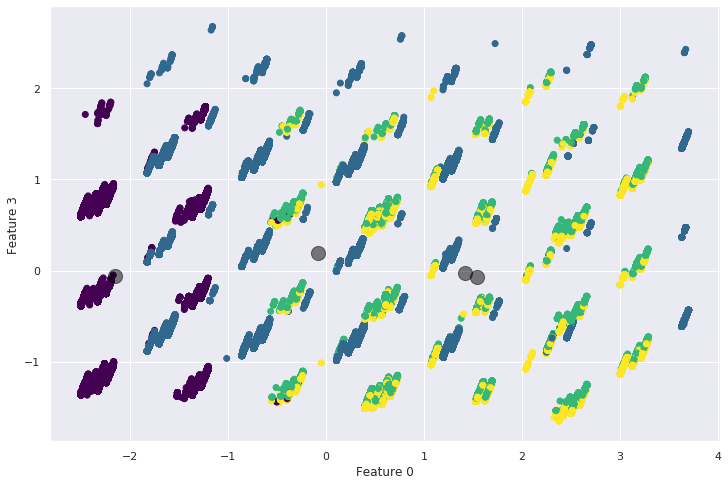

In [396]:
# plot the cluster assignments and cluster centers
plt.scatter(bla[:, 0], bla[:, 4], c=y_kmeans, cmap="viridis")
plt.scatter(centers[:, 0], centers[:, 4], c="black", s=200, alpha=0.5)
plt.xlabel("Feature 0")
plt.ylabel("Feature 3")
plt.show()